<a href="https://colab.research.google.com/github/AhMedDa1/Graduation-Project/blob/main/Graduation_project_onePixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One Pixel Attack 


## Imports

In [ ]:
#@title Imports

import google.colab
!git clone https://github.com/Hyperparticle/one-pixel-attack-keras.git
!mv -v one-pixel-attack-keras/* .
!rm -rf one-pixel-attack-keras

# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

# Custom Networks
from networks.lenet import LeNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

## Load Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

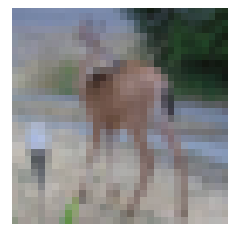

In [ ]:
image_id = 100 #@param {type:"integer"} # Image index in the test set
helper.plot_image(x_test[image_id])

## Image Perturbation

In [ ]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

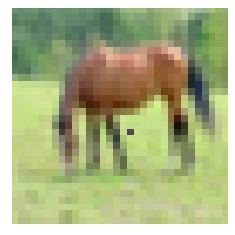

In [ ]:
image_id =  60#@param {type:"integer"} # Image index in the test set
#@markdown <h3>pixel :</h3>
x = 18  #@param {type: "slider", min: 0, max: 32}
y = 17  #@param {type: "slider", min: 0, max: 32}
#@markdown <h3>color :</h3>
r = 74  #@param {type: "slider", min: 0, max: 256}
g = 73  #@param {type: "slider", min: 0, max: 256}
b = 82  #@param {type: "slider", min: 0, max: 256}


pixel = np.array([x, y, r, g, b]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]

helper.plot_image(image_perturbed)

## Load Models

There are two models included in this notbooke, `lenet` and `resnet` 


In [ ]:
lenet = LeNet()
resnet = ResNet()

models = [lenet, resnet]



Successfully loaded lenet
Successfully loaded resnet


### Calculate Model Accuracies

In [ ]:
network_stats, correct_imgs = helper.evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating lenet
Evaluating resnet


,name,accuracy,param_count
0,lenet,0.7488,62006
1,resnet,0.9231,470218


*Prediction Function*

In [ ]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

Below we can modify a pixel in an image and see how the confidence of the model changes. In almost all cases, the confidence will not change. However, for very special cases it will change drastically.

Confidence in true class horse is 0.9999989
Prior confidence was 0.9999974


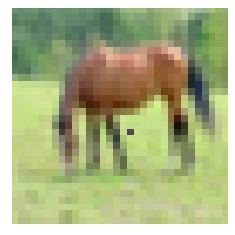

In [ ]:
image_id =  60#@param {type:"integer"} # Image index in the test set
#@markdown <h3>pixel :</h3>
x = 18  #@param {type: "slider", min: 0, max: 32}
y = 17  #@param {type: "slider", min: 0, max: 32}
#@markdown <h3>color :</h3>
r = 74  #@param {type: "slider", min: 0, max: 256}
g = 73  #@param {type: "slider", min: 0, max: 256}
b = 82  #@param {type: "slider", min: 0, max: 256}

pixel = np.array([x, y, r, g, b]) # pixel = x,y,r,g,b
model = resnet #@param ["lenet", "resnet"]


true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
confidence = predict_classes(pixel, x_test[image_id], true_class, model)[0]

print('Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])





The Attack

Here we will demonstrate two variants of the one pixel attack: untargeted and targeted.

### Success of attack

In [ ]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True

Confidence: 0.07460086
Prior confidence 0.50054187
Attack success: True


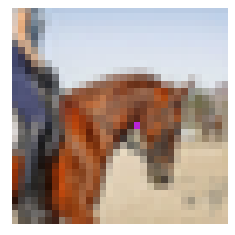

In [ ]:
image_id =  541#@param {type:"integer"} # Image index in the test set
x = 17  #@param {type: "slider", min: 0, max: 32}
y = 18  #@param {type: "slider", min: 0, max: 32}
#@markdown <h3>color :</h3>
r = 185  #@param {type: "slider", min: 0, max: 256}
g = 36   #@param {type: "slider", min: 0, max: 256}
b = 215  #@param {type: "slider", min: 0, max: 256}

pixel = np.array([x, y, r, g, b]) # pixel = x,y,r,g,b
model = resnet #@param ["lenet", "resnet"]

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
success = attack_success(pixel, x_test[image_id], true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

Attack Function

In [ ]:
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img_id, 0]
    
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class, 
                              model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, x_test[img_id])[0]
    prior_probs = model.predict_one(x_test[img_id])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img_id, 0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x]

Untargeted Attack

Confidence: 0.9672414
Confidence: 0.9672414
Confidence: 0.95962137
Confidence: 0.9151302
Confidence: 0.8049248
Confidence: 0.6323222
Confidence: 0.24552558


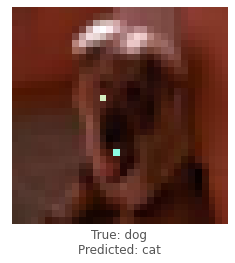

In [ ]:
image_id =  991#@param {type:"integer"} # Image index in the test set
pixels =  2#@param {type:"integer"} # Number of pixels to attack
model = resnet #@param ["lenet", "resnet"]

a = attack(image_id, model, pixel_count=pixels, verbose=True)

#### Targeted Attack

Attacking with target bird


/content/differential_evolution.py:585: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12
Confidence: 3.027832e-12


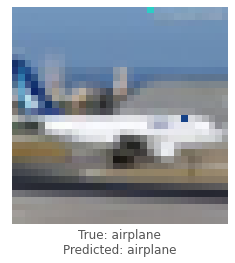

In [ ]:
image_id =  90#@param {type:"integer"} # Image index in the test set
pixels =  2#@param {type:"integer"} # Number of pixels to attack
target_class = 2#@param {type:"integer"} # Integer in range 0-9
model = resnet #@param ["lenet", "resnet"]

print('Attacking with target', class_names[target_class])
_ = attack(image_id, model, target_class, pixel_count=pixels, verbose=True)

### Collect Results

In [ ]:
def attack_all(models, samples=500, pixels=(1,3,5), targeted=False, 
               maxiter=75, popsize=400, verbose=False):
    results = []
    for model in models:
        model_results = []
        valid_imgs = correct_imgs[correct_imgs.name == model.name].img
        img_samples = np.random.choice(valid_imgs, samples, replace=False)
        
        for pixel_count in pixels:
            for i, img_id in enumerate(img_samples):
                print('\n', model.name, '- image', img_id, '-', i+1, '/', len(img_samples))
                targets = [None] if not targeted else range(10)
                
                for target in targets:
                    if targeted:
                        print('Attacking with target', class_names[target])
                        if target == y_test[img_id, 0]:
                            continue
                    result = attack(img_id, model, target, pixel_count, 
                                    maxiter=maxiter, popsize=popsize, 
                                    verbose=verbose)
                    model_results.append(result)
                    
        results += model_results
        helper.checkpoint(results, targeted)
    return results


 lenet - image 4657 - 1 / 2


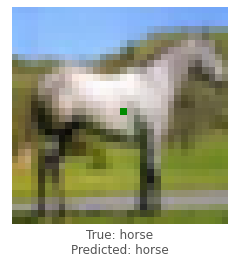


 lenet - image 1083 - 2 / 2


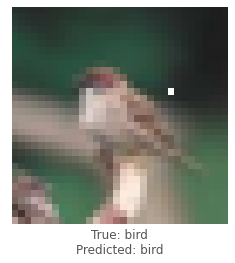


 lenet - image 4657 - 1 / 2


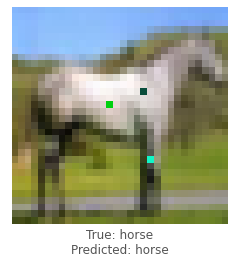


 lenet - image 1083 - 2 / 2


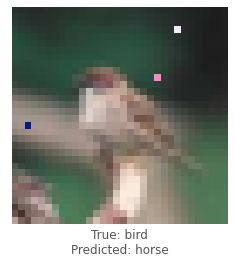


 lenet - image 4657 - 1 / 2


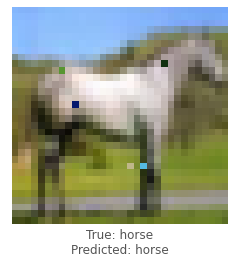


 lenet - image 1083 - 2 / 2


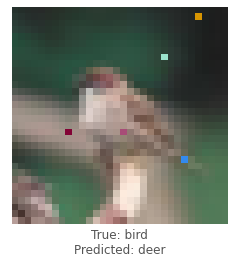


 resnet - image 9387 - 1 / 2


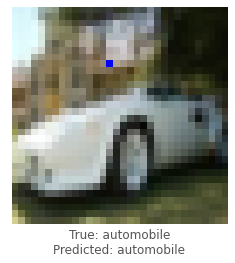


 resnet - image 9147 - 2 / 2


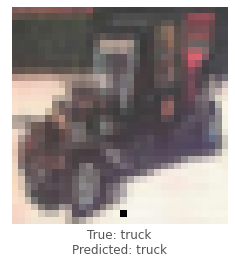


 resnet - image 9387 - 1 / 2


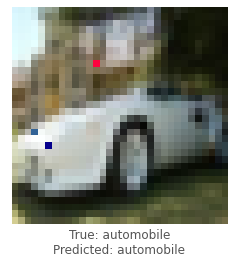


 resnet - image 9147 - 2 / 2


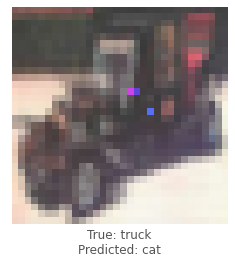


 resnet - image 9387 - 1 / 2


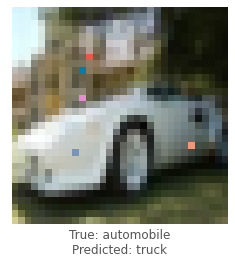


 resnet - image 9147 - 2 / 2


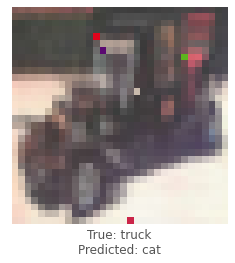

In [ ]:
untargeted = attack_all(models, samples=1, targeted=False)


 lenet - image 8230 - 1 / 2
Attacking with target airplane
Attacking with target automobile


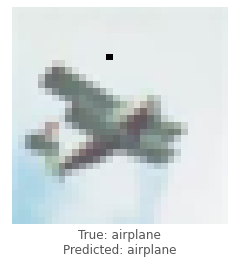

Attacking with target bird


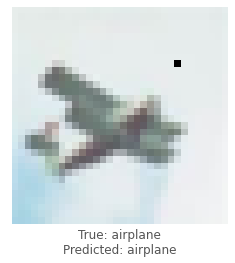

Attacking with target cat


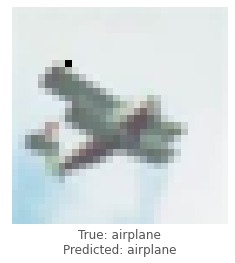

Attacking with target deer


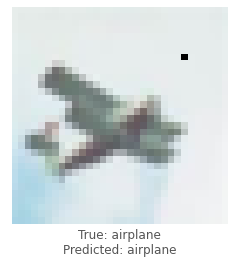

Attacking with target dog


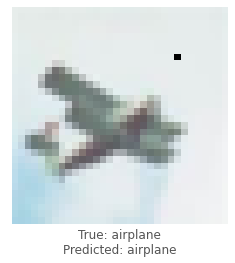

Attacking with target frog


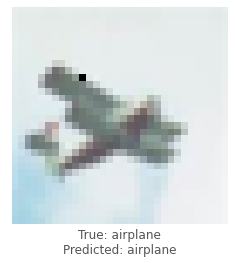

Attacking with target horse


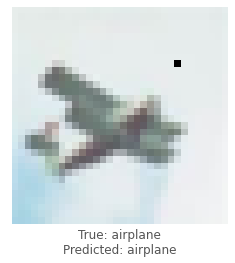

Attacking with target ship


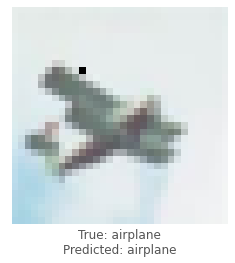

Attacking with target truck


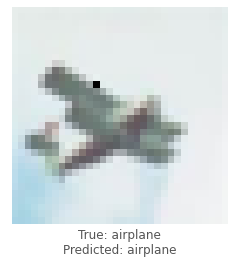


 lenet - image 5157 - 2 / 2
Attacking with target airplane


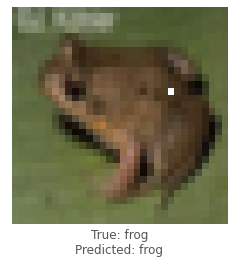

Attacking with target automobile


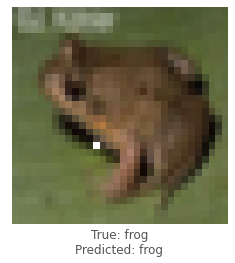

Attacking with target bird


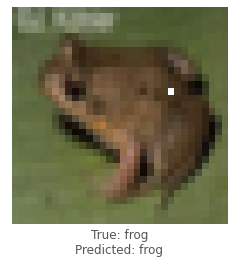

Attacking with target cat


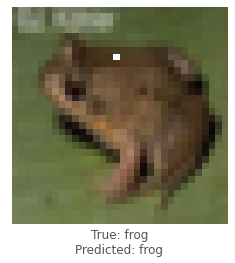

Attacking with target deer


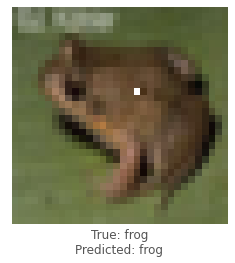

Attacking with target dog


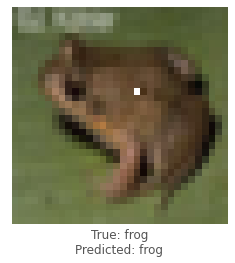

Attacking with target frog
Attacking with target horse


/content/differential_evolution.py:585: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


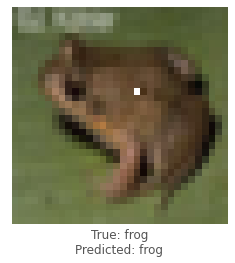

Attacking with target ship


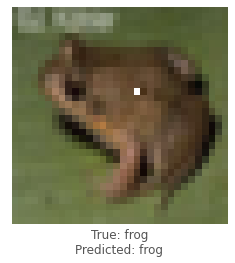

Attacking with target truck


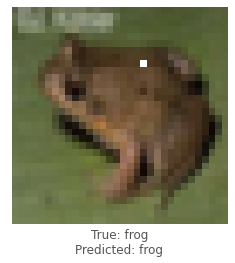


 lenet - image 8230 - 1 / 2
Attacking with target airplane
Attacking with target automobile


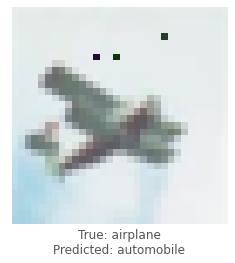

Attacking with target bird


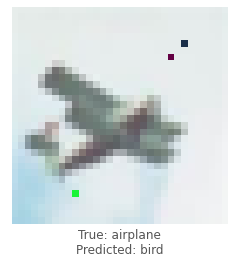

Attacking with target cat


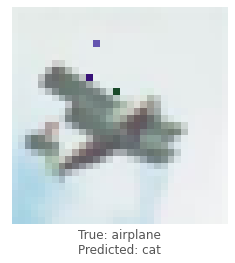

Attacking with target deer


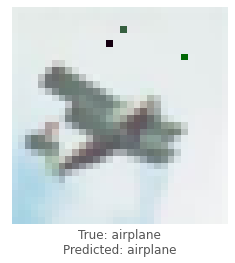

Attacking with target dog


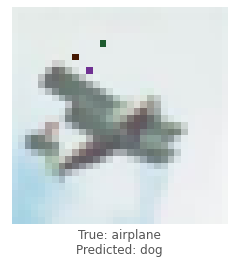

Attacking with target frog


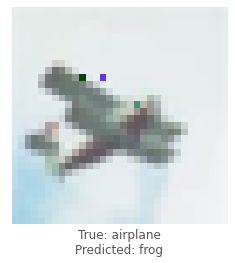

Attacking with target horse


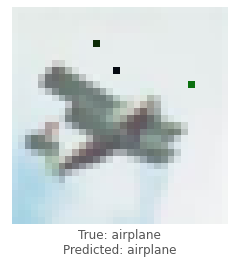

Attacking with target ship


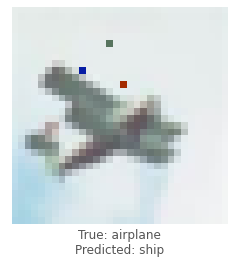

Attacking with target truck


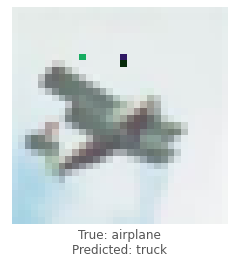


 lenet - image 5157 - 2 / 2
Attacking with target airplane


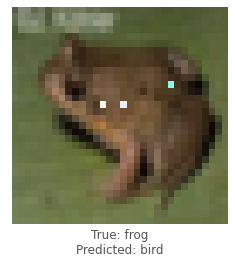

Attacking with target automobile


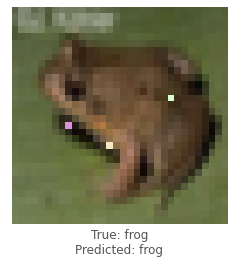

Attacking with target bird


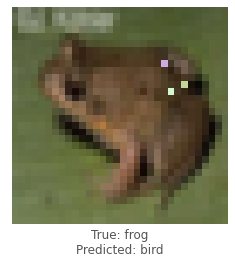

Attacking with target cat


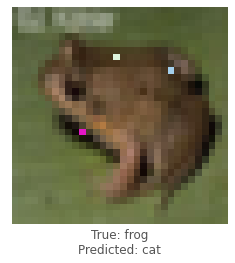

Attacking with target deer


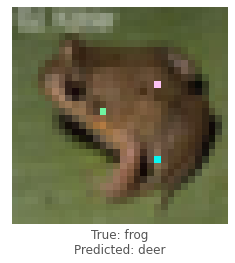

Attacking with target dog


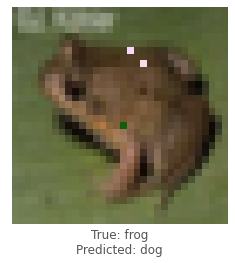

Attacking with target frog
Attacking with target horse


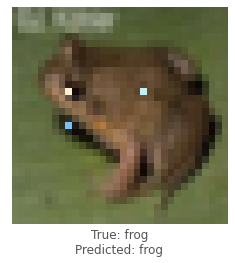

Attacking with target ship


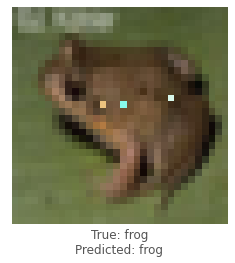

Attacking with target truck


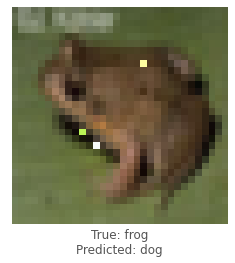


 lenet - image 8230 - 1 / 2
Attacking with target airplane
Attacking with target automobile


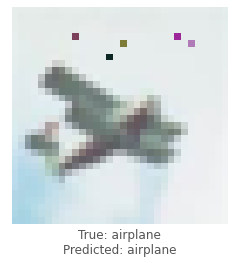

Attacking with target bird


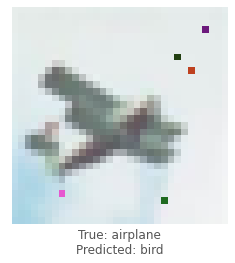

Attacking with target cat


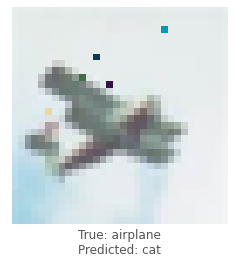

Attacking with target deer


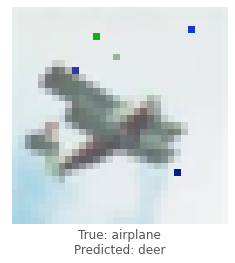

Attacking with target dog


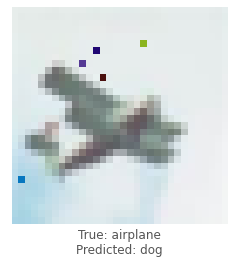

Attacking with target frog


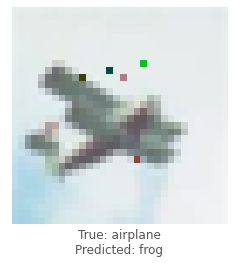

Attacking with target horse


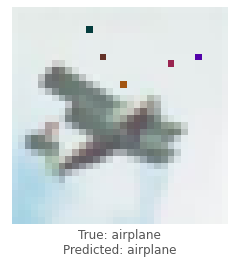

Attacking with target ship


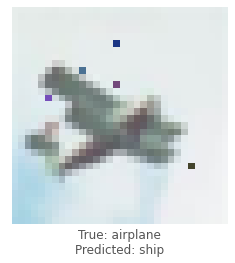

Attacking with target truck


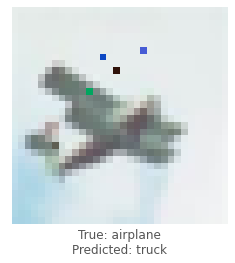


 lenet - image 5157 - 2 / 2
Attacking with target airplane


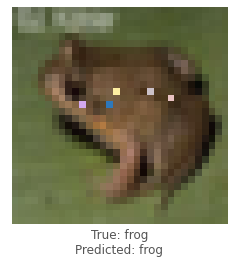

Attacking with target automobile


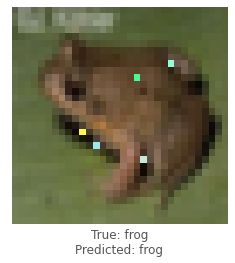

Attacking with target bird


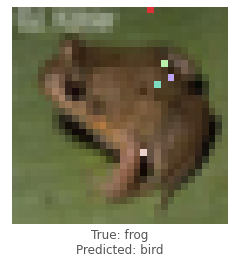

Attacking with target cat


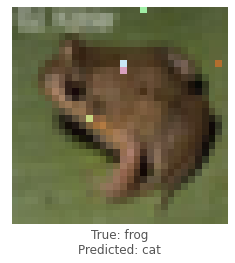

Attacking with target deer


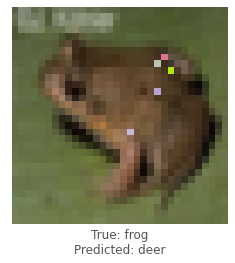

Attacking with target dog


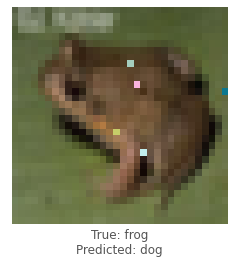

Attacking with target frog
Attacking with target horse


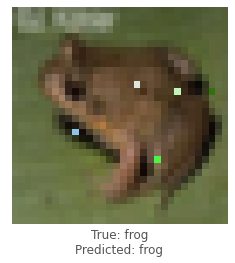

Attacking with target ship


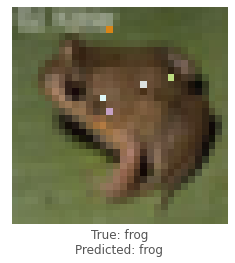

Attacking with target truck


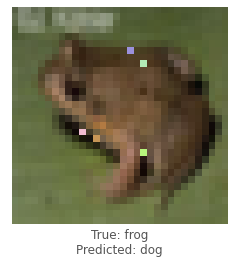


 resnet - image 9723 - 1 / 2
Attacking with target airplane


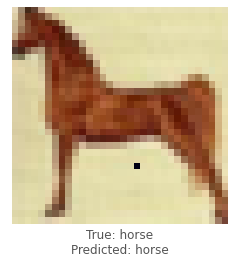

Attacking with target automobile


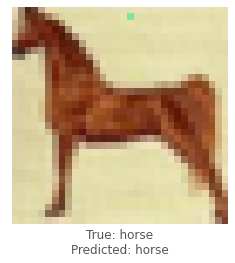

Attacking with target bird


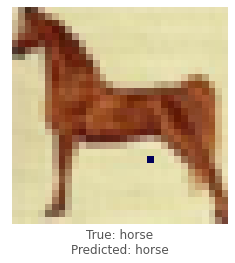

Attacking with target cat


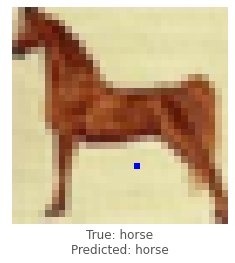

Attacking with target deer


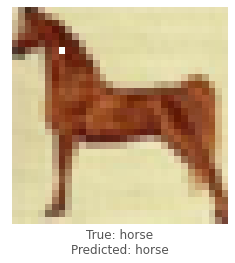

Attacking with target dog


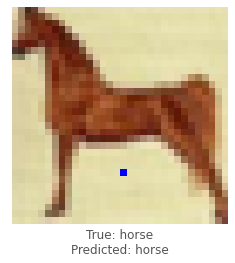

Attacking with target frog


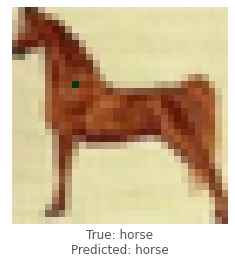

Attacking with target horse
Attacking with target ship


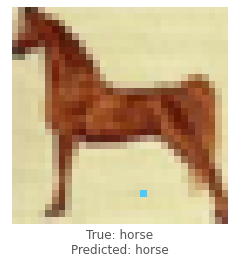

Attacking with target truck


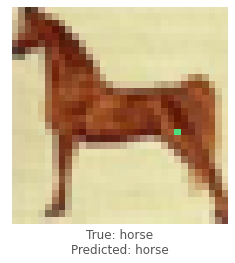


 resnet - image 528 - 2 / 2
Attacking with target airplane


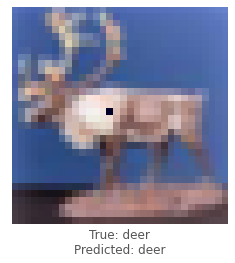

Attacking with target automobile


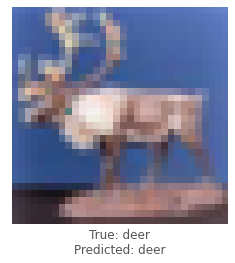

Attacking with target bird


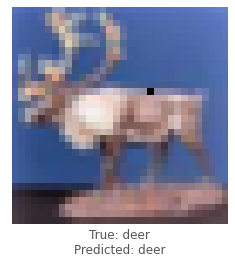

Attacking with target cat


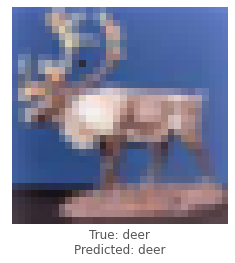

Attacking with target deer
Attacking with target dog


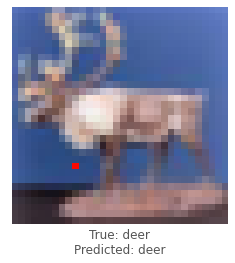

Attacking with target frog


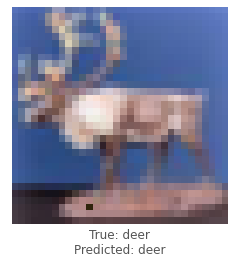

Attacking with target horse


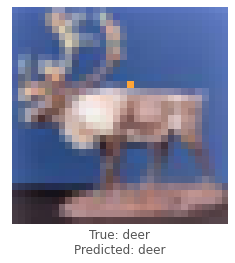

Attacking with target ship


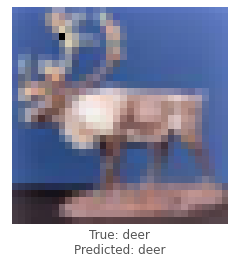

Attacking with target truck


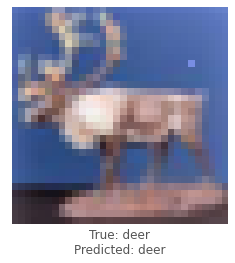


 resnet - image 9723 - 1 / 2
Attacking with target airplane


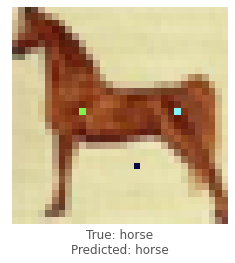

Attacking with target automobile


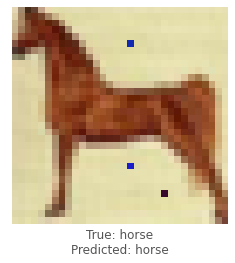

Attacking with target bird


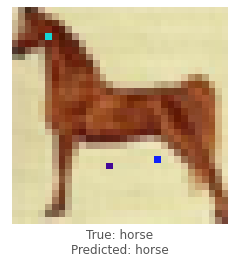

Attacking with target cat


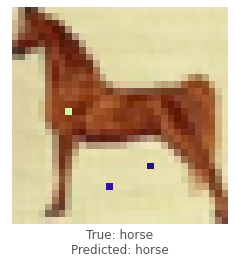

Attacking with target deer


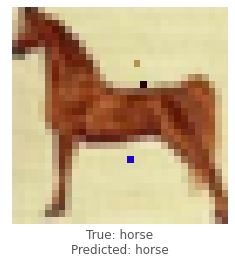

Attacking with target dog


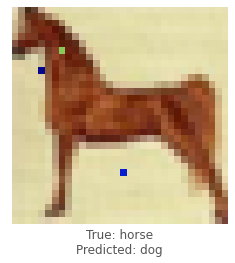

Attacking with target frog


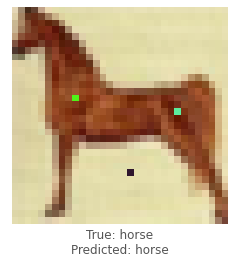

Attacking with target horse
Attacking with target ship


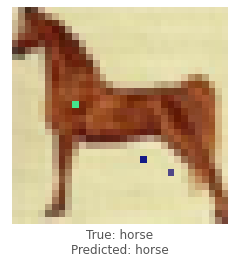

Attacking with target truck


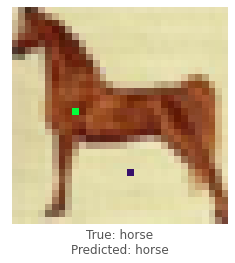


 resnet - image 528 - 2 / 2
Attacking with target airplane


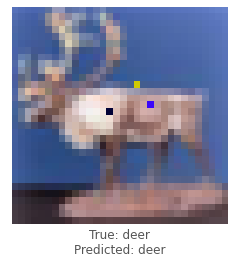

Attacking with target automobile


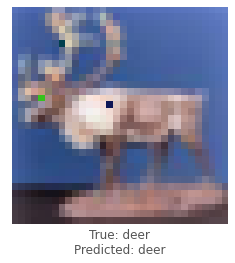

Attacking with target bird


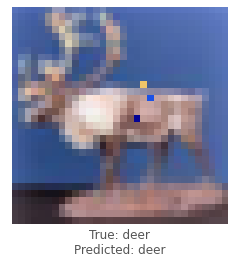

Attacking with target cat


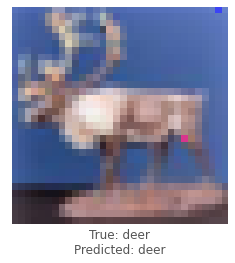

Attacking with target deer
Attacking with target dog


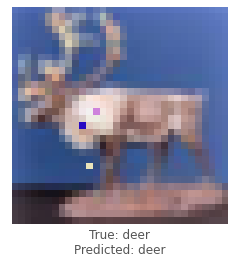

Attacking with target frog


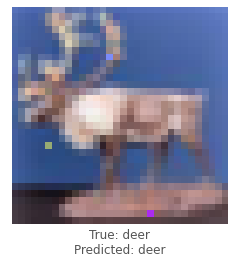

Attacking with target horse


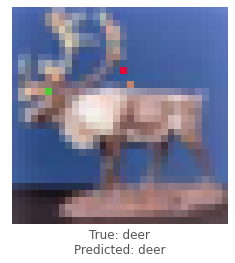

Attacking with target ship


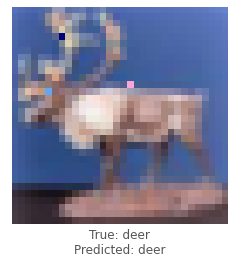

Attacking with target truck


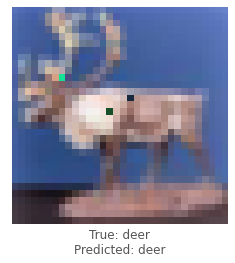


 resnet - image 9723 - 1 / 2
Attacking with target airplane


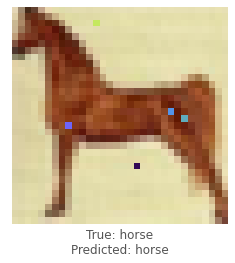

Attacking with target automobile


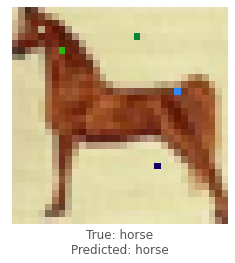

Attacking with target bird


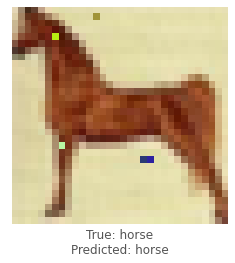

Attacking with target cat


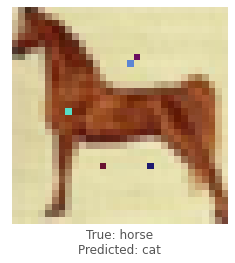

Attacking with target deer


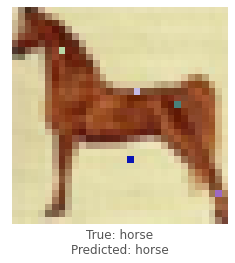

Attacking with target dog


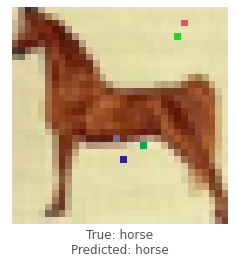

Attacking with target frog


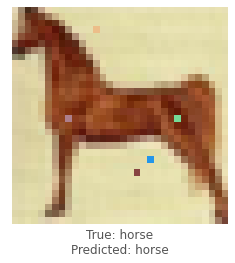

Attacking with target horse
Attacking with target ship


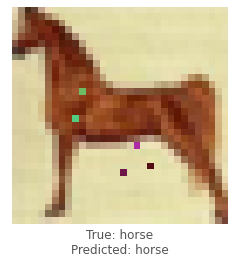

Attacking with target truck


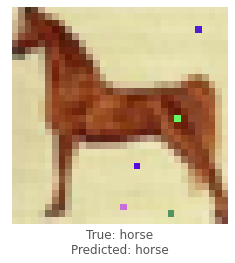


 resnet - image 528 - 2 / 2
Attacking with target airplane


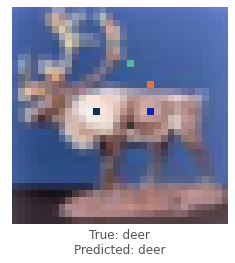

Attacking with target automobile


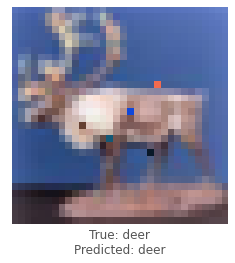

Attacking with target bird


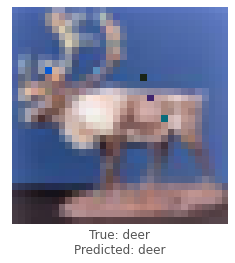

Attacking with target cat


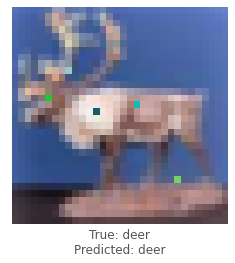

Attacking with target deer
Attacking with target dog


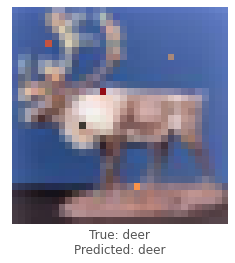

Attacking with target frog


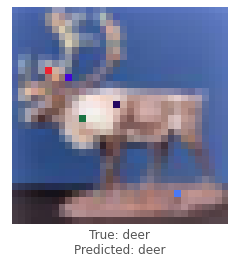

Attacking with target horse


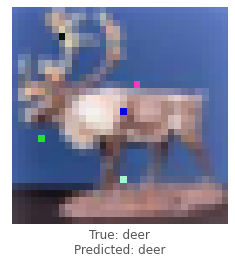

Attacking with target ship


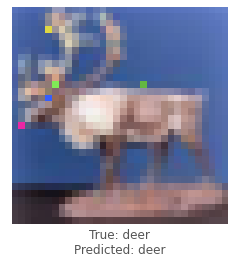

Attacking with target truck


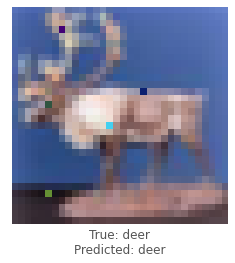

In [ ]:
targeted = attack_all(models, samples=1, targeted=True)

###  Statistics

Print the final results! 

In [ ]:
# Load the results
untargeted, targeted = helper.load_results()

In [ ]:
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'perturbation']
untargeted_results = pd.DataFrame(untargeted, columns=columns)
targeted_results = pd.DataFrame(targeted, columns=columns)

#### Untargeted

In [ ]:
helper.attack_stats(untargeted_results, models, network_stats,)

,model,accuracy,pixels,attack_success_rate
0,lenet,0.7488,1,0.0
1,lenet,0.7488,3,0.5
2,lenet,0.7488,5,0.5
3,resnet,0.9231,1,0.0
4,resnet,0.9231,3,0.5
5,resnet,0.9231,5,1.0


#### Targeted

In [ ]:
helper.attack_stats(targeted_results, models, network_stats)

,model,accuracy,pixels,attack_success_rate
0,lenet,0.7488,1,0.000000
1,lenet,0.7488,3,0.722222
2,lenet,0.7488,5,0.666667
3,resnet,0.9231,1,0.000000
4,resnet,0.9231,3,0.055556
5,resnet,0.9231,5,0.055556
